In [1]:
import os
import random
from collections import defaultdict
from typing import Iterable, Sized

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models

from tqdm import tqdm
from torch import optim
from torchvision import transforms
from torchvision.models import ResNeXt50_32X4D_Weights
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader

from helpers.datasets import custom_collate_proposals_fn, CrackDataset2
from helpers.early_stopping import EarlyStopping

In [2]:
class Resnext50BasedClassifierForProposals(nn.Module):
    def __init__(
            self,
            input_shape: tuple[int, int, int] = (3, 224, 224),
            linear_layers_features: int = 512
    ):
        super().__init__()

        self.feature_extractor = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._get_feature_size(input_shape), linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, 1)
        )

    def _get_feature_size(self, shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            features = self.feature_extractor(dummy_input)

            return features.numel()

    def forward(self, x):
        features = self.feature_extractor(x)
        class_scores = self.classifier(features)

        return class_scores

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [4]:
proposal_cache = defaultdict(list)
SELECTIVE_SEARCH_BATCH_SIZE = 6


def perform_selective_search(image: np.ndarray, image_path: str, batch_size: int = SELECTIVE_SEARCH_BATCH_SIZE) -> torch.Tensor:
    """
    Perform selective search and return the largest proposals (by area) in three batches after shuffling.
    Cache the proposals based on the image path to avoid redundant computation.
    
    Args:
    - image: The input image as a numpy array.
    - image_path: The file path to the image (used as the cache key).
    - batch_size: The size of each batch
    
    Yields:
    - A batch of proposals as a torch.Tensor of shape [batch_size, 4].
    """
    if image_path in proposal_cache:
        for start in range(0, len(proposal_cache[image_path]), batch_size):
            yield torch.tensor(proposal_cache[image_path][start:start + batch_size], dtype=torch.float32)
    else:
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()

        rects = ss.process()
        boxes = []

        for (x, y, w, h) in rects:
            area = w * h

            boxes.append((x, y, x + w, y + h, area))

        boxes = sorted(boxes, key=lambda b: b[4], reverse=True)
        boxes = [(x1, y1, x2, y2) for x1, y1, x2, y2, area in boxes]
        num_proposals = min(len(boxes), 2 * batch_size)
        top_proposals = boxes[:num_proposals]

        random.shuffle(top_proposals)

        proposal_cache[image_path] = top_proposals

        for start in range(0, num_proposals, batch_size):
            yield torch.tensor(top_proposals[start:start + batch_size], dtype=torch.float32)

In [5]:
def get_loaders() -> tuple[DataLoader, DataLoader]:
    train_images_dir = os.path.join("data", "train_small", "images")
    valid_images_dir = os.path.join("data", "valid_small", "images")
    train_coco_path = os.path.join("data", "train", "coco_annotations.json")
    valid_coco_path = os.path.join("data", "valid", "coco_annotations.json")
    train_dataset = CrackDataset2(
        perform_selective_search, 
        train_coco_path,
        train_images_dir
    )
    valid_dataset = CrackDataset2(
        perform_selective_search,
        valid_coco_path,
        valid_images_dir
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=custom_collate_proposals_fn
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=custom_collate_proposals_fn
    )

    return train_dataloader, valid_dataloader

In [6]:
def get_loop_objects() -> tuple[Resnext50BasedClassifierForProposals, EarlyStopping, torch.nn.BCEWithLogitsLoss, optim.Adam]:
    model = Resnext50BasedClassifierForProposals()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    early_stopping = EarlyStopping(patience=2, verbose=True, delta=0)

    model.to(device)

    return model, early_stopping, criterion, optimizer

In [7]:
num_epochs = 25
checkpoint_path = os.path.join("checkpoints", f"resnext50_32x4d_classifier_with_proposals.pt")
train_loader, valid_loader = get_loaders()
model, early_stopping, criterion, optimizer = get_loop_objects()
history = {
    "train_loss": [],
    "valid_loss": []
}
valid_accuracy = 0


def chunkify(x: Iterable | Sized) -> Iterable[Iterable]:
    for i in range(0, len(x), SELECTIVE_SEARCH_BATCH_SIZE):
        yield x[i:i + SELECTIVE_SEARCH_BATCH_SIZE]


for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images_group, proposals_group, labels_group in epoch_progress:
        optimizer.zero_grad()

        batch_loss = 0.0

        for image, proposals, labels in zip(images_group, proposals_group, labels_group):
            cropped_proposals_with_labels = []

            for idx, proposal in enumerate(proposals):
                label = labels[idx]
                x_min, y_min, x_max, y_max = proposal.int()
                cropped_region = image[:, y_min:y_max, x_min:x_max]
                resized_region = resize(cropped_region, [224, 224])

                cropped_proposals_with_labels.append((label, resized_region))

            aggregated_predictions = []
            aggregated_labels = []

            for chunk in chunkify(cropped_proposals_with_labels):
                labels_batch, proposals_batch = zip(*chunk)
                labels_batch = torch.stack(labels_batch)
                regions = torch.stack(proposals_batch).to(device)
                predictions = model(regions).cpu()
                predictions = predictions.squeeze(1)

                torch.cuda.empty_cache()
                aggregated_predictions.extend(predictions)
                aggregated_labels.extend(labels_batch)

            final_predictions = torch.stack(aggregated_predictions)
            final_labels = torch.stack(aggregated_labels)
            loss = criterion(final_predictions, final_labels)
            batch_loss += loss
            predicted = (final_predictions > 0.5).float()
            correct_train += (predicted == final_labels).sum().item()
            total_train += final_labels.numel()

        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item()

        epoch_progress.set_postfix(loss=train_loss / total_train, accuracy=100. * correct_train / total_train)

    model.eval()

    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images_group, proposals_group, labels_group in valid_loader:
            for image, proposals, labels in zip(images_group, proposals_group, labels_group):
                cropped_proposals_with_labels = []

                for idx, proposal in enumerate(proposals):
                    label = labels[idx]
                    x_min, y_min, x_max, y_max = proposal.int()
                    cropped_region = image[:, y_min:y_max, x_min:x_max]
                    resized_region = resize(cropped_region, [224, 224])

                    cropped_proposals_with_labels.append((label, resized_region))

                aggregated_predictions = []
                aggregated_labels = []

                for chunk in chunkify(cropped_proposals_with_labels):
                    labels_batch, proposals_batch = zip(*chunk)
                    labels_batch = torch.stack(labels_batch)
                    regions = torch.stack(proposals_batch).to(device)
                    predictions = model(regions).cpu()
                    predictions = predictions.squeeze(1)

                    aggregated_predictions.extend(predictions)
                    aggregated_labels.extend(labels_batch)

                final_predictions = torch.stack(aggregated_predictions)
                final_labels = torch.stack(aggregated_labels)
                loss = criterion(final_predictions, final_labels)
                valid_loss += loss.item()
                predicted = (final_predictions > 0.5).float()
                correct_valid += (predicted == final_labels).sum().item()
                total_valid += final_labels.numel()

    valid_accuracy = 100. * correct_valid / total_valid
    avg_valid_loss = valid_loss / total_valid

    history["train_loss"].append(train_loss / total_train)
    history["valid_loss"].append(avg_valid_loss)
    print(f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
    early_stopping(avg_valid_loss, model, checkpoint_path)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1/25:   0%|          | 0/3 [00:00<?, ?batch/s]C:\Users\mmale\.conda\envs\crack_detection_torch_1\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/25: 100%|██████████| 3/3 [03:13<00:00, 64.40s/batch, accuracy=49.9, loss=0.0679]


Validation Loss: 0.0636, Validation Accuracy: 54.31%
Validation loss decreased (inf --> 0.063607).  Saving model ...


Epoch 2/25: 100%|██████████| 3/3 [03:10<00:00, 63.52s/batch, accuracy=49.9, loss=0.0634]


Validation Loss: 0.0628, Validation Accuracy: 54.31%
Validation loss decreased (0.063607 --> 0.062838).  Saving model ...


Epoch 3/25: 100%|██████████| 3/3 [03:07<00:00, 62.34s/batch, accuracy=49.9, loss=0.0581]


Validation Loss: 0.0619, Validation Accuracy: 52.40%
Validation loss decreased (0.062838 --> 0.061924).  Saving model ...


Epoch 4/25: 100%|██████████| 3/3 [02:54<00:00, 58.14s/batch, accuracy=50.4, loss=0.0509]


Validation Loss: 0.0609, Validation Accuracy: 54.31%
Validation loss decreased (0.061924 --> 0.060863).  Saving model ...


Epoch 5/25: 100%|██████████| 3/3 [02:49<00:00, 56.36s/batch, accuracy=60, loss=0.042]   


Validation Loss: 0.1515, Validation Accuracy: 39.62%
EarlyStopping counter: 1 out of 2


Epoch 6/25: 100%|██████████| 3/3 [02:08<00:00, 42.92s/batch, accuracy=81.1, loss=0.0317]


Validation Loss: 0.0539, Validation Accuracy: 59.74%
Validation loss decreased (0.060863 --> 0.053866).  Saving model ...


Epoch 7/25: 100%|██████████| 3/3 [02:54<00:00, 58.18s/batch, accuracy=94.1, loss=0.0208]


Validation Loss: 0.3493, Validation Accuracy: 64.86%
EarlyStopping counter: 1 out of 2


Epoch 8/25: 100%|██████████| 3/3 [02:46<00:00, 55.38s/batch, accuracy=99.3, loss=0.0107]


Validation Loss: 4.1188, Validation Accuracy: 51.12%
EarlyStopping counter: 2 out of 2
Early stopping triggered


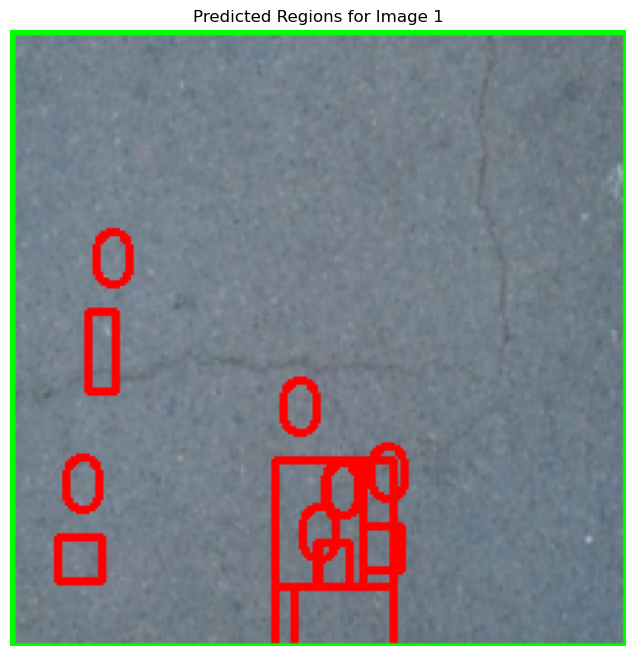

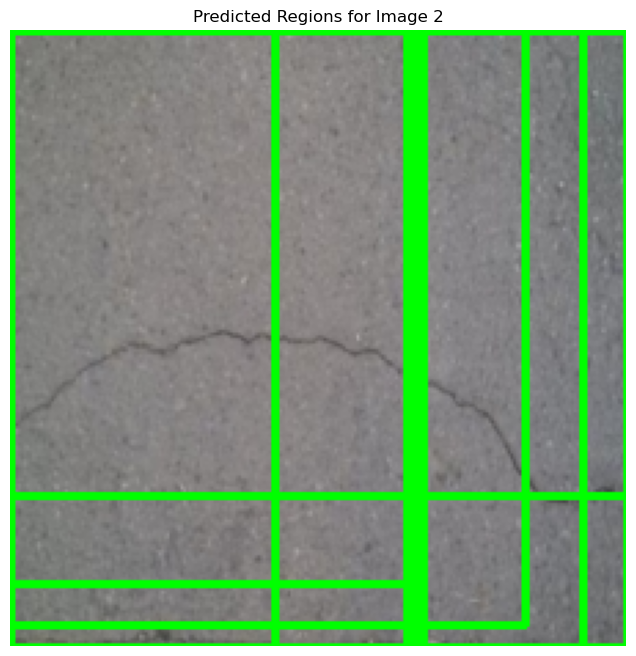

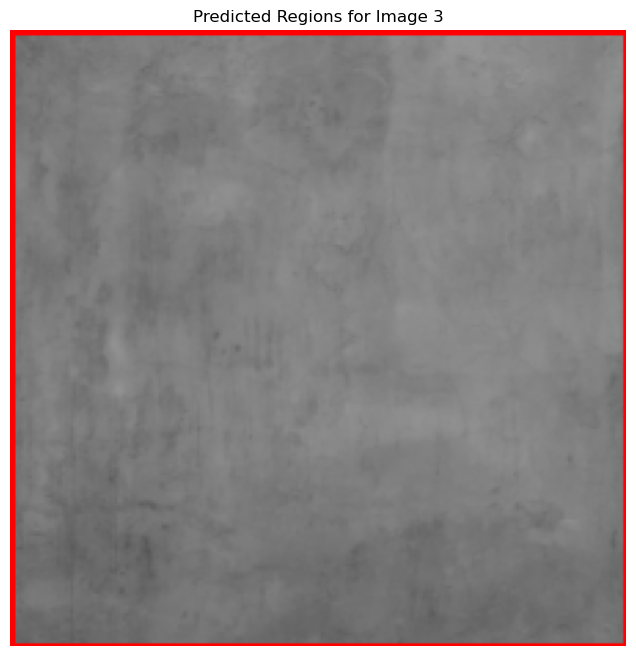

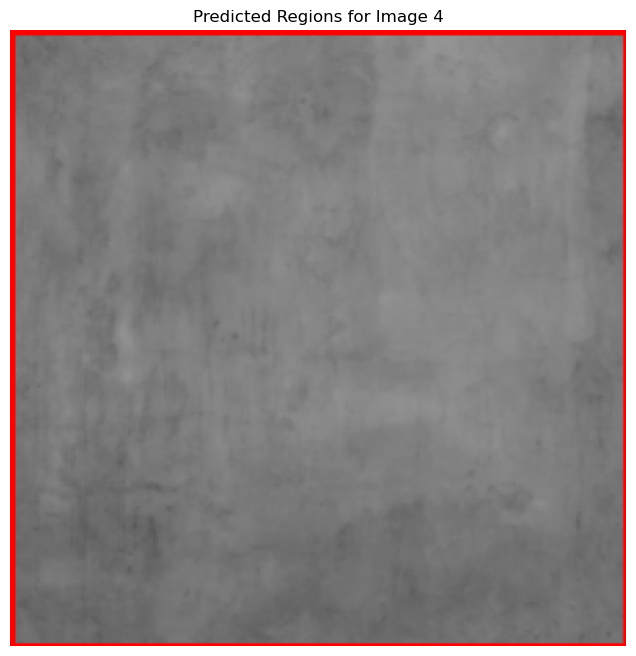

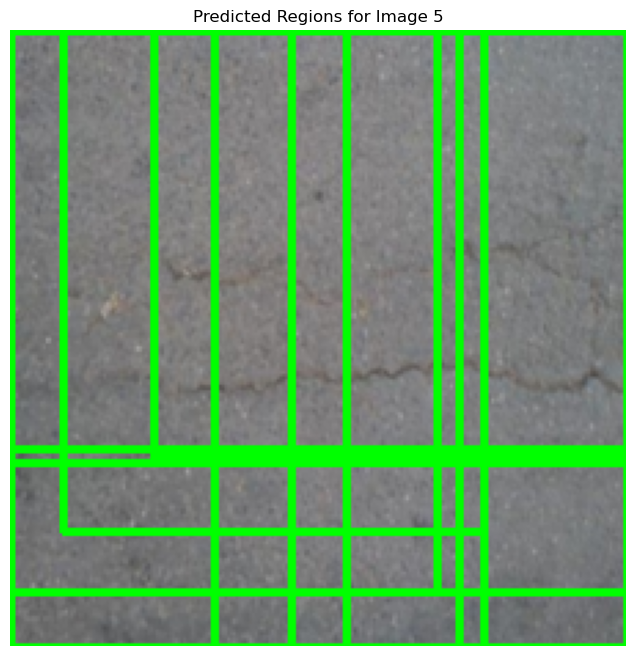

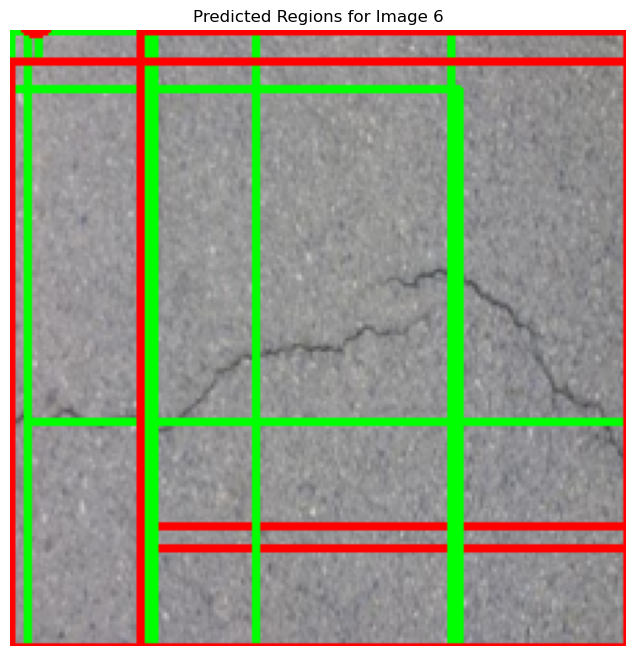

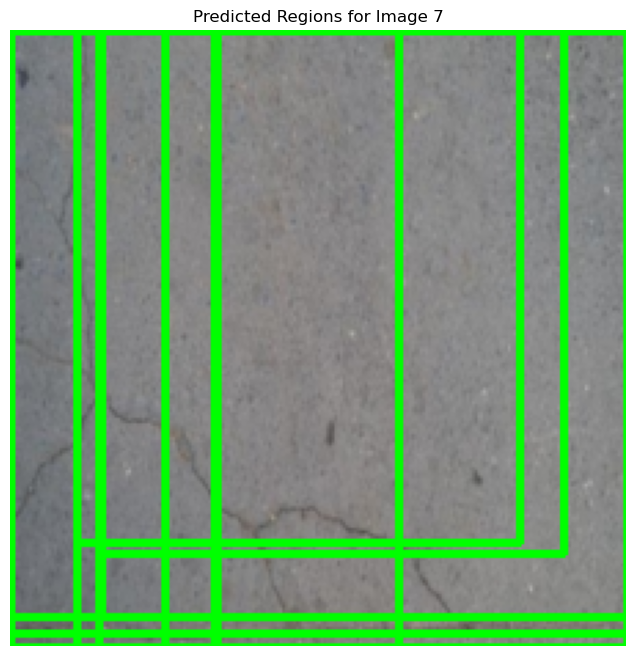

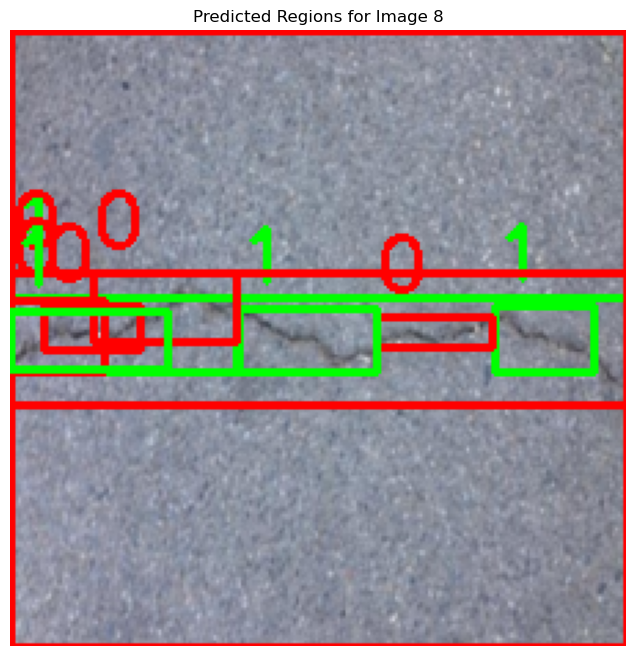

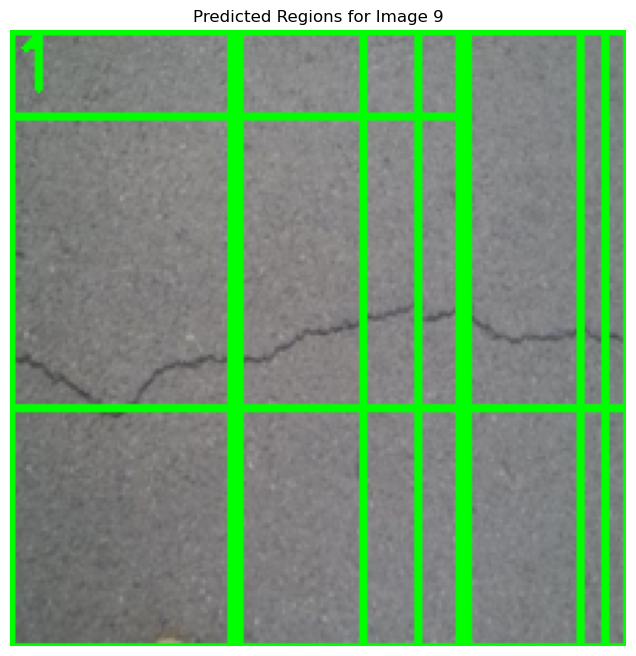

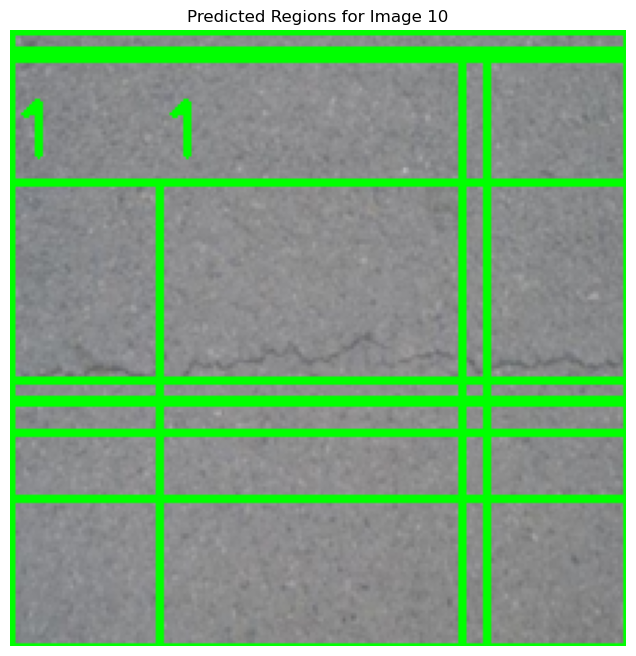

In [8]:
model.eval()
images_shown = 0
should_end = False

with torch.no_grad():
    for images_group, proposals_group, _ in valid_loader:
        if should_end:
            break
        
        for image, proposals in zip(images_group, proposals_group):
            if images_shown >= 10:
                should_end = True
                break

            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)
            image_with_boxes = image_np.copy()

            for proposal in proposals:
                x_min, y_min, x_max, y_max = proposal.int()
                x_min = x_min.item()
                y_min = y_min.item()
                x_max = x_max.item()
                y_max = y_max.item()
                cropped_region = image[:, y_min:y_max, x_min:x_max].unsqueeze(0).to(device)
                prediction = model(cropped_region).cpu().squeeze()
                label = "1" if prediction > 0.5 else "0"
                color = (0, 255, 0) if label == "1" else (0, 0, 255)

                cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, 2)
                cv2.putText(image_with_boxes, label, (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f"Predicted Regions for Image {images_shown+1}")
            plt.axis('off')
            plt.show()

            images_shown += 1